## Overview
- <b><font color='red'>Structured Streaming is a scalable and fault-tolerant stream processing engine built on the Spark SQL engine.</font></b> 
- You can express your streaming computation the same way you would express a batch computation on static data. 
- The Spark SQL engine will take care of running it incrementally and continuously and updating the final result as streaming data continues to arrive.
- You can use the <b>Dataset/DataFrame API</b> in Scala, Java, Python or R to express streaming aggregations, event-time windows, stream-to-batch joins, etc.
- The computation is executed on the same optimized Spark SQL engine. 
- Finally, the system ensures end-to-end exactly-once fault-tolerance guarantees through checkpointing and Write-Ahead Logs. 
- <b><font color='red'>In short, Structured Streaming provides fast, scalable, fault-tolerant, end-to-end exactly-once stream processing without the user having to reason about streaming.</font></b> 
- Internally, by default, Structured Streaming queries are processed using a micro-batch processing engine, which processes data streams as a series of small batch jobs thereby achieving end-to-end latencies as low as <b>100 milliseconds</b> and <b>exactly-once</b> fault-tolerance guarantees. However, since Spark 2.3, a new low-latency processing mode called <b>Continuous Processing</b> is introduced, which can achieve end-to-end latencies as low as <b>1 millisecond</b> with <b>at-least-once</b> guarantees. Without changing the Dataset/DataFrame operations in your queries, you will be able to choose the mode based on your application requirements.

### at-most-once delivery

means that for each message handed to the mechanism, that message is delivered zero or one times; in more casual terms it means that messages may be lost.

### at-least-once delivery

means that for each message handed to the mechanism potentially multiple attempts are made at delivering it, such that at least one succeeds; again, in more casual terms this means that messages may be duplicated but not lost.

### exactly-once delivery

means that for each message handed to the mechanism exactly one delivery is made to the recipient; the message can neither be lost nor duplicated.

<b> The first one is the cheapest—highest performance, least implementation overhead—because it can be done in a fire-and-forget fashion without keeping state at the sending end or in the transport mechanism. The second one requires retries to counter transport losses, which means keeping state at the sending end and having an acknowledgement mechanism at the receiving end. The third is most expensive—and has consequently worst performance—because in addition to the second it requires state to be kept at the receiving end in order to filter out duplicate deliveries</b>

## The Philosophy of Structured Streaming
- Structured Streaming was designed from scratch with one core philosophy—for developers, <b>writing stream processing pipe‐lines should be as easy as writing batch pipelines.</b> 
- In a nutshell, the guiding principles of Structured Streaming are:
    - <b>A single, unified programming model and interface for batch and stream processing.</b>This unified model offers a simple API interface for both batch and streaming workloads. You can use familiar SQL or batch-like DataFrame queries on your stream as you would on a batch, leaving dealing with the underlying complexities of fault tolerance, optimizations, and tardy data to the engine.
    - <b>A broader definition of stream processing</b>. Big data processing applications have grown complex enough that the line between real-time processing and batch processing has blurred significantly. The aim with Structured Streaming was to broaden its applicability from traditional stream processing to a larger class of applications; any application that periodically (e.g., every few hours) to continuously (like traditional streaming applications) processes data should be expressible using Structured Streaming.

## The Programming Model of Structured Streaming
- “Table” is a well-known concept that developers are familiar with when building
batch applications. Structured Streaming extends this concept to streaming applications by treating a stream as an unbounded, continuously appended table, as illustrated in the following figure:
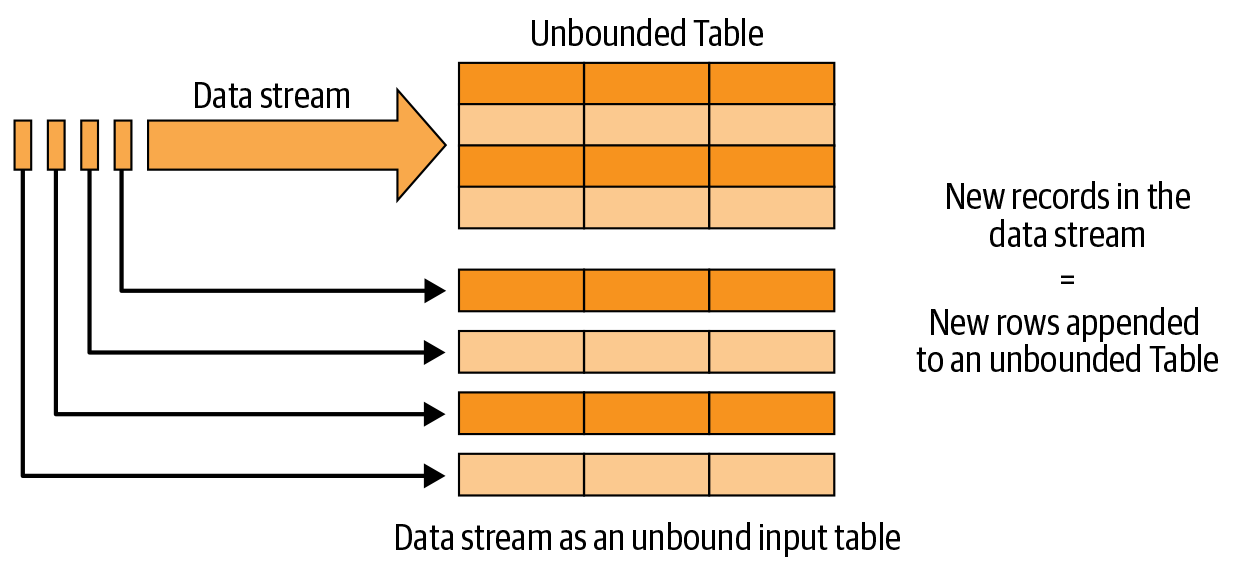
- Every new record received in the data stream is like a new row being appended to the
unbounded input table.
- Structured Streaming will not actually retain all the input,
but the output produced by Structured Streaming until time T will be equivalent to
having all of the input until T in a static, bounded table and running a batch job on
the table.
- As shown in following figure, the developer then defines a query on this conceptual input
table, as if it were a static table, to compute the result table that will be written to an
output sink.
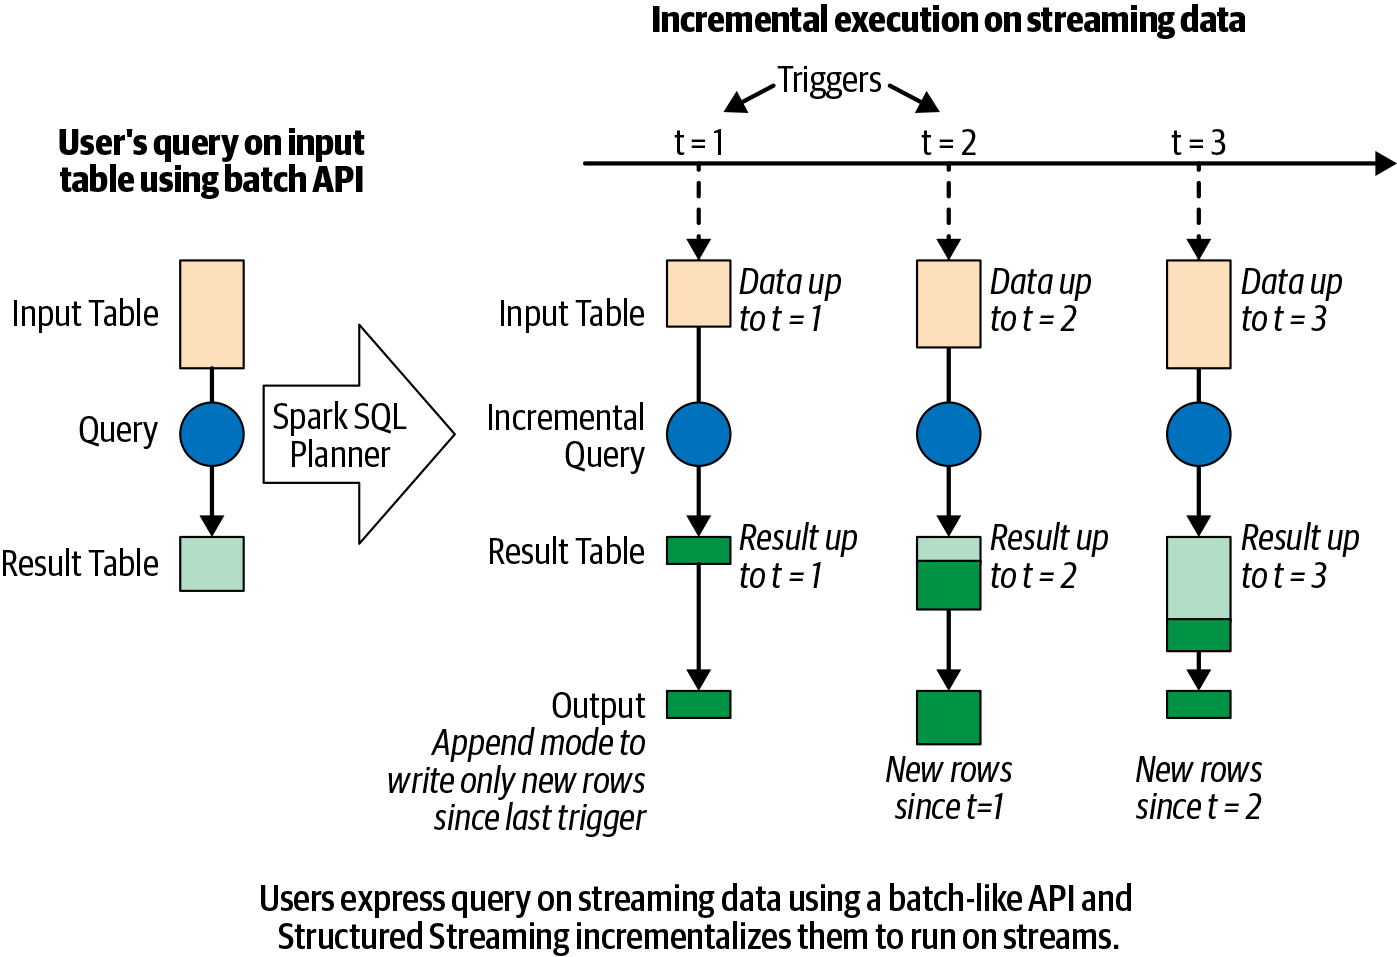
- Structured Streaming will automatically convert this batch-like query to
a streaming execution plan. This is called <b><i>incrementalization: </b></i>Structured Streaming
figures out what state needs to be maintained to update the result each time a record
arrives.
- Finally, developers specify triggering policies to control when to update the
results.
- Each time a trigger fires, Structured Streaming checks for new data (i.e., a new
row in the input table) and incrementally updates the result.
- The last part of the model is the output mode. Each time the result table is updated,
the developer will want to write the updates to an external system, such as a filesystem (e.g., HDFS, Amazon S3) or a database (e.g., MySQL, Cassandra).
- We usually
want to write output incrementally. For this purpose, Structured Streaming provides
three output modes:
    - <b>Append mode: </b>Only the new rows appended to the result table since the last trigger will be written to the external storage. This is applicable only in queries where existing rows
in the result table cannot change (e.g., a map on an input stream).
    - <b>Update mode: </b>
Only the rows that were updated in the result table since the last trigger will be
changed in the external storage. This mode works for output sinks that can be
updated in place, such as a MySQL table.
    - <b>Complete mode: </b>
The entire updated result table will be written to external storage.
- Thinking of the data streams as tables not only makes it easier to conceptualize the
logical computations on the data, but also makes it easier to express them in code.
- Since Spark’s DataFrame is a programmatic representation of a table, you can use the
DataFrame API to express your computations on streaming data. All you need to do
is define an input DataFrame (i.e., the input table) from a streaming data source, and
then you apply operations on the DataFrame in the same way as you would on a
DataFrame defined on a batch source.

## The Fundamentals of a Structured Streaming Query
### Five Steps to Define a Streaming Query:
- Structured Streaming uses the same DataFrame
API as batch queries to express the data processing logic. However, there are a few key differences you need to know about for defining a Structured Streaming query.

### Step 1: Define input sources:
- As with batch queries, the first step is to define a <b>DataFrame</b> from a streaming source.
However, when reading batch data sources, we need <b>spark.read</b> to create a <b>DataFrameReader</b> , whereas with streaming sources we need <b>spark.readStream</b> to create a <b>DataStreamReader</b>.
- <b>DataStreamReader</b> has most of the same methods as <b>DataFrameReader</b> , so you can use it in a similar way.

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Sructured Streaming").getOrCreate()

In [ ]:
# creating a DataFrame from a text data stream to be received over a socket connection:
lines = (spark.readStream.format('socket')
         .option('host','localhost')
         .option('port',12345)
         .load()
        )

- The code above generates the lines DataFrame as an unbounded table of newline-separated text data read from <i>localhost:12345</i>.
- This table contains one column of strings named <b>“value”</b>, and each line in the streaming text data becomes a row in the table. 
- <b>Note that,</b> similar to batch sources with
spark.read , this does not immediately start reading the streaming data; it only sets
up the configurations necessary for reading the data once the streaming query is
explicitly started.
- Besides sockets, Apache Spark natively supports reading data streams from Apache
Kafka and all the various file-based formats that DataFrameReader supports (Parquet,
ORC, JSON, etc.).

### Step 2: Transform data:
- Now we can apply the usual DataFrame operations, such as splitting the lines into
individual words and then counting them.

In [ ]:
from pyspark.sql.functions import explode,split

In [ ]:
lines_splitted = lines.select(split(lines['value'],' ').alias('splittedLines'))

words = lines_splitted.select(explode(lines_splitted['splittedLines']).alias('word'))

## we can do it in one line
## words = lines.select(explode(split(lines.value,' ')).alias('word'))

# we have used two built-in SQL functions - split and explode, 
#to split each line into multiple rows with a word each.
# we use the function alias to name the new column as “word”

counts = words.groupBy("word").count()

- <b>counts</b> is a <b>streaming DataFrame</b> (that is, a DataFrame on unbounded, streaming data) that represents the running word counts that will be computed once the streaming query is started and the streaming input data is being continuously processed.

<b><font color='red'>Note that these operations to transform the lines streaming DataFrame would work in the exact same way if lines were a batch DataFrame.</font></b>
- In general, most DataFrame operations that can be applied on a batch DataFrame can also be applied on a streaming DataFrame.

To understand which operations are supported in Structured Streaming, you have to recognize the two broad classes of data transformations:

- <i><b>Stateless transformations: </b></i> Operations like <b>select() , filter() , map() , etc.</b> do not require any information
from previous rows to process the next row; each row can be processed by itself.
The lack of previous “state” in these operations make them stateless. Stateless
operations can be applied to both batch and streaming DataFrames.
- <i><b>Stateful transformations: </b></i> In contrast, an aggregation operation like <b>count()</b> requires maintaining state to
combine data across multiple rows. More specifically, any DataFrame operations
involving<b> grouping, joining, or aggregating</b> are stateful transformations. While
many of these operations are supported in Structured Streaming, a few combinations of them are not supported because it is either computationally hard or
infeasible to compute them in an incremental manner.

### Unsupported Operations
- Multiple streaming aggregations (i.e. a chain of aggregations on a streaming DF) are not yet supported on streaming Datasets.
- Limit and take the first N rows are not supported on streaming Datasets.
- Distinct operations on streaming Datasets are not supported.
- Deduplication operation is not supported after aggregation on a streaming Datasets.
- Sorting operations are supported on streaming Datasets only after an aggregation and in Complete Output Mode.
- Few types of outer joins on streaming Datasets are not supported. 
- In addition, there are some Dataset methods that will not work on streaming Datasets. They are actions that will immediately run queries and return results, which does not make sense on a streaming Dataset. Rather, those functionalities can be done by explicitly starting a streaming query.
    - <b>count() - </b>Cannot return a single count from a streaming Dataset. Instead, use ds.groupBy().count() which returns a streaming Dataset containing a running count.
    - <b>foreach() - </b>Instead use ds.writeStream.foreach(...).
    - <b>show() - </b>Instead use the console sink.

### Step 3: Define output sink and output mode:
- After transforming the data, we can define how to write the processed output data with <b>DataFrame.writeStream</b> (instead of DataFrame.write , used for batch data).
- This creates a <b>DataStreamWriter</b> which, similar to DataFrameWriter , has additional methods to specify the following:
    - Output writing details (where and how to write the output).
    - Processing details (how to process data and how to recover from failures).

In [ ]:
# writing the final counts to the console
writer = counts.writeStream.format("console").outputMode("complete")

### Step 4: Specify processing details
- The final step before starting the query is to specify details of how to process the data.

In [ ]:
checkpointDir = 'chkpnt'
writer2 = (writer.trigger(processingTime='1 second')
          .option('checkpointLocation',checkpointDir)
          )

- Here we have specified two types of details using the DataStreamWriter that we created with DataFrame.writeStream:
    - <b>Triggering details: </b>This indicates when to trigger the discovery and processing of newly available streaming data. There are four options:
        - <b>Default: </b> When the trigger is not explicitly specified, then by default, the streaming query executes data in micro-batches where the next micro-batch is triggered as soon as the previous micro-batch has completed.
        - <b>Processing time with trigger interval: </b>You can explicitly specify the ProcessingTime trigger with an interval, and the query will trigger micro-batches at that fixed interval.
        - <b>Once: </b>In this mode, the streaming query will execute exactly one micro-batch—it processes all the new data available in a single batch and then stops itself. This is useful when you want to control the triggering and processing from an external scheduler that will restart the query using any custom schedule <i>(e.g., to control cost by only executing a query once per day).</i>
        - <b>Continuous: </b>This is an experimental mode (as of Spark 3.0) where the streaming query will process data continuously instead of in micro-batches. While only a small subset of DataFrame operations allow this mode to be used, it can provide much lower latency (as low as milliseconds) than the micro-batch trigger modes.
    - <b> Checkpoint location: </b>This is a directory in any HDFS-compatible filesystem where a streaming query saves its progress information—that is, what data has been successfully processed. Upon failure, this metadata is used to restart the failed query exactly where it left off. Therefore, setting this option is necessary for failure recovery with exactly-once guarantees.
    
### Important about trigger(processingTime):
For a Spark Streaming application running on a cluster to be stable, the system should be able to process data as fast as it is being received. In other words, batches of data should be processed as fast as they are being generated. 
Whether this is true for an application can be found by monitoring the processing times in the streaming web UI, where the batch processing time should be less than the batch interval.
Depending on the nature of the streaming computation, the batch interval used may have significant impact on the data rates that can be sustained by the application on a fixed set of cluster resources.
For example, let us consider the earlier WordCountNetwork example. For a particular data rate, the system may be able to keep up with reporting word counts every 2 seconds (i.e., batch interval of 2 seconds), but not every 500 milliseconds. So the batch interval needs to be set such that the expected data rate in production can be sustained.
A good approach to figure out the right batch size for your application is to test it with a conservative batch interval (say, 5-10 seconds) and a low data rate. To verify whether the system is able to keep up with the data rate, you can check the value of the end-to-end delay experienced by each processed batch.
If the delay is maintained to be comparable to the batch size, then system is stable. Otherwise, if the delay is continuously increasing, it means that the system is unable to keep up and it therefore unstable. Once you have an idea of a stable configuration, you can try increasing the data rate and/or reducing the batch size.

In [ ]:
# Default trigger (runs micro-batch as soon as it can)
df.writeStream \
  .format("console") \
  .start()

# ProcessingTime trigger with two-seconds micro-batch interval
df.writeStream \
  .format("console") \
  .trigger(processingTime='2 seconds') \
  .start()

# One-time trigger
df.writeStream \
  .format("console") \
  .trigger(once=True) \
  .start()

# Continuous trigger with one-second checkpointing interval
df.writeStream
  .format("console")
  .trigger(continuous='1 second')
  .start()

In [ ]:
streamingQuery = writer2.start()

- The returned object of type streamingQuery represents an active query and can be
used to manage the query.
- <b>Note that</b> <i>start()</i> is a nonblocking method, so it will return as soon as the query has
started in the background.
- If you want the main thread to block until the streaming
query has terminated, you can use <b>streamingQuery.awaitTermination()</b>.
- If the
query fails in the background with an error, <i>awaitTermination()</i> will also fail with
that same exception.
- You can wait up to a timeout duration using <b>awaitTermination(timeoutMillis)</b> ,
and you can explicitly stop the query with <b>streamingQuery.stop()</b>.

In [ ]:
streamingQuery.stop()

### Putting it all together
- <b>To summarize</b><i>, here is the complete code for reading streams of text data over a
socket, counting the words, and printing the counts to the console:</i>

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Sructured Streaming").getOrCreate()

In [2]:
from pyspark.sql.functions import *
lines = (spark
         .readStream.format("socket")
         .option("host", "localhost")
         .option("port", 12345)
         .load())
#words = lines.select(split(col("value"), "\\s").alias("word"))
words = lines.select(explode(split(lines.value, " ")).alias("word"))
counts = words.groupBy("word").count()
checkpointDir = "chkpnt"
streamingQuery = (counts.writeStream
                  .format("console")
                  .outputMode("complete")
                  .trigger(processingTime="30 second")
                  .option("checkpointLocation", checkpointDir)
                  .start())
# streamingQuery.awaitTermination()

22/06/10 16:32:54 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.
22/06/10 16:32:59 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+



22/06/10 16:33:31 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 30000 milliseconds, but spent 31160 milliseconds


-------------------------------------------
Batch: 1
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|  too|    1|
|hello|    2|
|again|    1|
|  and|    1|
|   hi|    2|
| then|    1|
+-----+-----+



In [3]:
streamingQuery.stop()

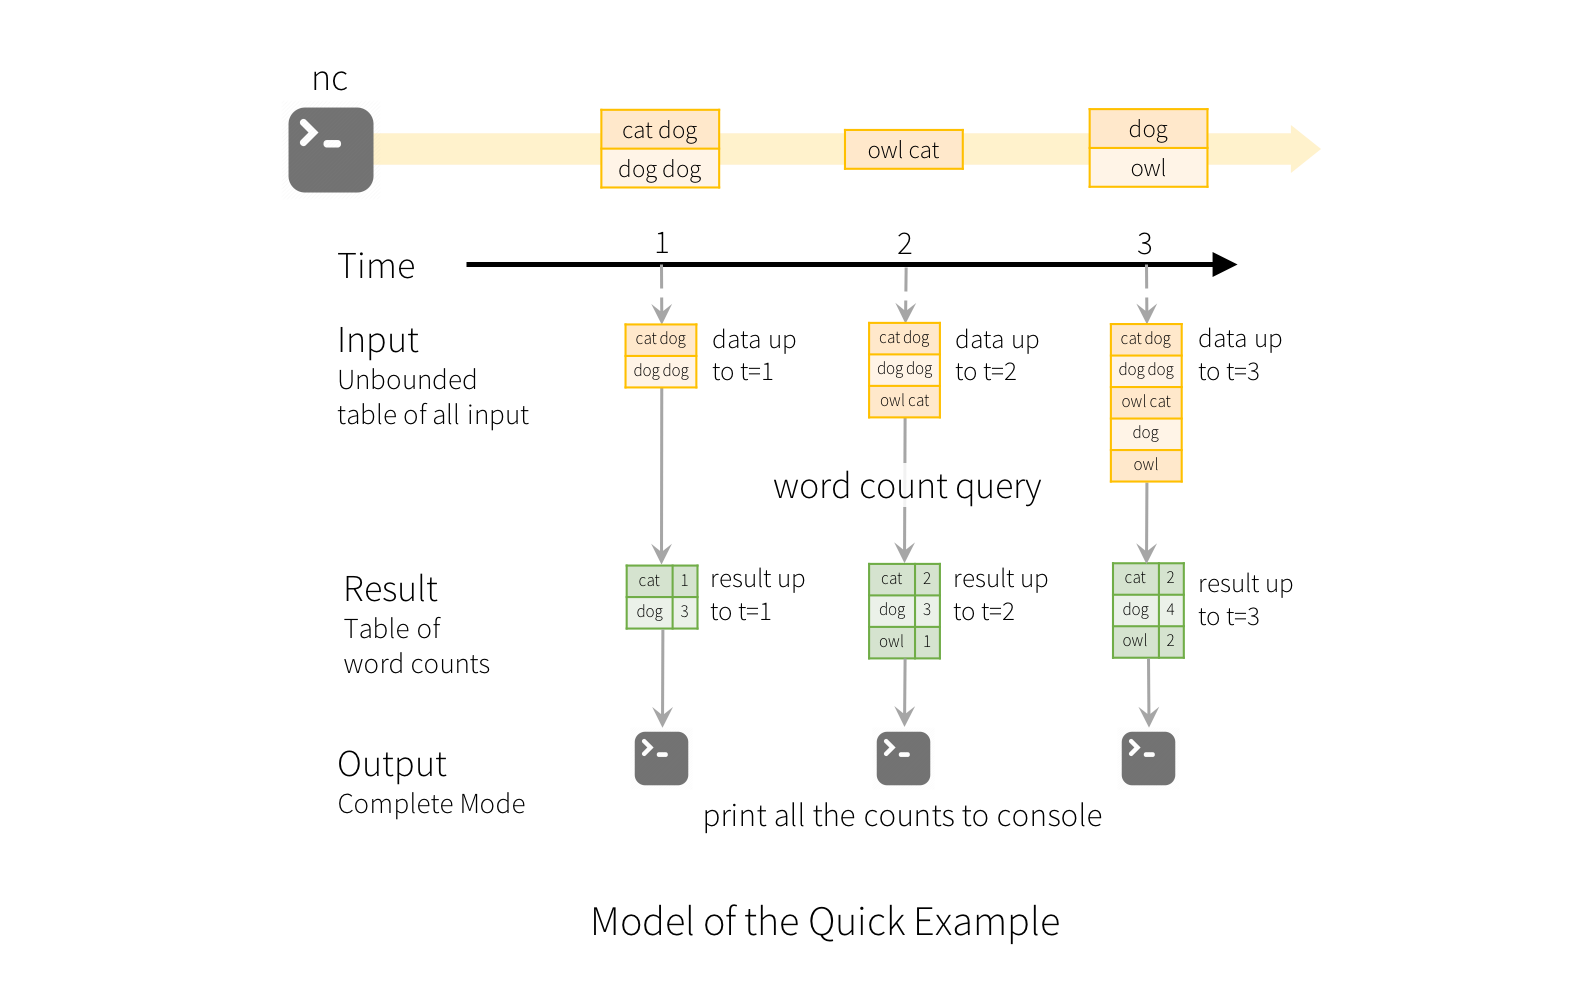